<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/submit_moving22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリのインポート

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

# データの読み込み

In [66]:
train = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/sample_submit.csv", header=None)

# 時系列データの確認

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  2101 non-null   object
 1   y         2101 non-null   int64 
 2   client    2101 non-null   int64 
 3   close     2101 non-null   int64 
 4   price_am  2101 non-null   int64 
 5   price_pm  2101 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 98.6+ KB


datetimeがobjectになっているので、datetime64に変換する（時系列データとして扱うことができる）

In [68]:
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  365 non-null    datetime64[ns]
 1   client    365 non-null    int64         
 2   close     365 non-null    int64         
 3   price_am  365 non-null    int64         
 4   price_pm  365 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 14.4 KB


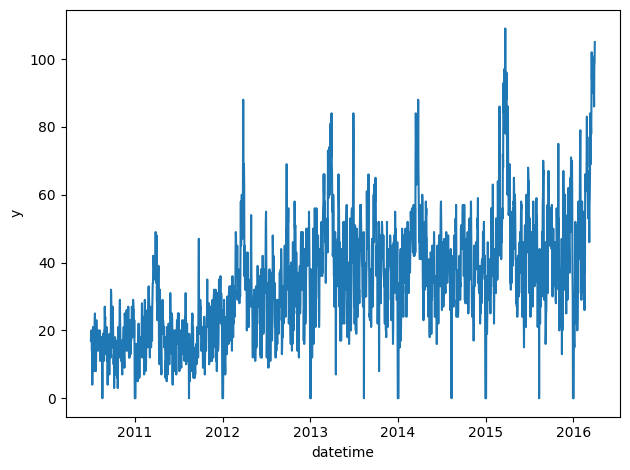

In [69]:
fig, ax = plt.subplots()

ax.plot(train['datetime'], train['y'])
ax.set_xlabel('datetime')
ax.set_ylabel('y')
plt.tight_layout()

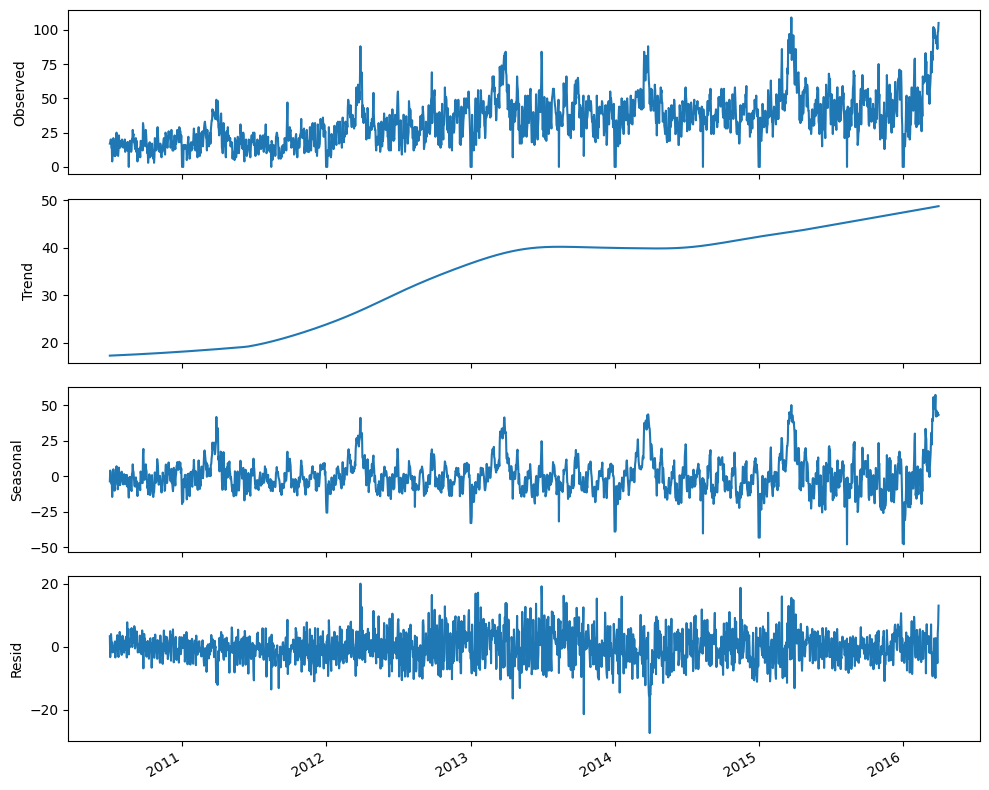

In [70]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# STL関数を使って時系列分解
# 期間は頻度mに等しい：日時データを使うので期間はm=365とする
decomposition = STL(train["y"], period=365).fit()

# 分解結果のプロット
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

# datetimeカラムを取得
datetime_col = train["datetime"]

# 生データ
ax1.plot(datetime_col, decomposition.observed)
ax1.set_ylabel('Observed')

# トレンド
ax2.plot(datetime_col, decomposition.trend)
ax2.set_ylabel('Trend')

# 季節性
ax3.plot(datetime_col, decomposition.seasonal)
ax3.set_ylabel('Seasonal')

# 残差
ax4.plot(datetime_col, decomposition.resid)
ax4.set_ylabel('Resid')

# x軸のフォーマットを調整
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

ピークが３月４月にあり、１年後tの季節性があることがわかる。Prophetを用いることができる。

# Prophetによるモデル構築

# 学習データで評価

EDAで作成した特徴量を追加する

In [71]:
merged_df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/merged_df_2.csv")

In [72]:
merged_df.columns

Index(['datetime', 'y', 'client', 'price_am', 'price_pm', 'trend', 'seasonal',
       'residual', 'y_bc_1_2', 'client_mean', 'price_am_mean', 'price_pm_mean',
       'is_train', 'y_lag_365', 'price_am_lag_1', 'price_pm_lag_1',
       'price_am_lag_7', 'price_pm_lag_7', 'price_am_lag_30',
       'price_pm_lag_30', 'price_am_lag_90', 'price_pm_lag_90',
       'price_am_lag_365', 'price_pm_lag_365', 'price_am_moving_avg_7',
       'price_am_moving_avg_30', 'price_am_moving_avg_90',
       'price_pm_moving_avg_7', 'price_pm_moving_avg_30',
       'price_pm_moving_avg_90', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'week_of_month', 'is_wknd', 'is_month_start',
       'is_month_end', 'quarter', 'is_quarter_start', 'is_quarter_end',
       'is_year_start', 'is_year_end', 'is_holiday', 'season', 'rokuyo',
       'golden_week', 'obon', 'new_year', 'JPNRGDPEXP', 'LRUN64TTJPM156S',
       'JPNCPIALLMINMEI', 'QJPN628BIS', 'LCEAPR03JPM661S', 'JPNCPIHOUMINMEI',
       'IRSTCB01JPM

In [73]:
# ProphetのDataFrameに変換（ds:日付列、y:目的変数）
df = merged_df.rename(columns={"datetime": "ds"})
df['ds'] = pd.to_datetime(df["ds"])

# 別で時系列を作成するので削除
df.drop(['seasonal', 'trend', 'residual', 'y_bc_1_2', 'y_lag_365'], axis=1, inplace=True)

# 欠損値は一旦０に
df = df.fillna(0)

# trainデータの最後の１年を評価データセットする
train = df[:-731]
valid = df[1551:1917]
test = df[-365:]

In [74]:
# Prophetモデルのインスタンス作成（初期化）
m = Prophet(seasonality_mode='multiplicative')

# 追加のレグレッサ（特徴量）をモデルに追加（yとdsを除くすべての列）
for column in df.columns.drop(['ds', 'y']):
    m.add_regressor(column)

# 日本の祝日を追加
m.add_country_holidays(country_name='Japan')

# 月次の季節性を追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=8)

# 訓練データを使用してモデルを学習
m.fit(train)

# 365日先までの予測用データフレームを作成
# future = m.make_future_dataframe(periods=365)
future = pd.concat([train, valid])

# 予測結果を生成
forecast = m.predict(future)

display(forecast.head(), forecast.tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/kem4rdto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/psabgpxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11622', 'data', 'file=/tmp/tmpm3xeokjk/kem4rdto.json', 'init=/tmp/tmpm3xeokjk/psabgpxf.json', 'output', 'file=/tmp/tmpm3xeokjk/prophet_modelnhas3_yz/prophet_model-20240928142811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Autumnal Equinox,Autumnal Equinox_lower,Autumnal Equinox_upper,Children's Day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,7.089000,-2.868006,11.966199,7.089000,7.089000,0.0,0.0,0.0,0.0,...,0.144706,0.144706,0.144706,-0.344018,-0.344018,-0.344018,0.0,0.0,0.0,4.822366
1,2011-01-02,7.099804,-6.112485,9.942714,7.099804,7.099804,0.0,0.0,0.0,0.0,...,0.144706,0.144706,0.144706,-0.390447,-0.390447,-0.390447,0.0,0.0,0.0,2.154506
2,2011-01-03,7.110607,-9.721656,5.645091,7.110607,7.110607,0.0,0.0,0.0,0.0,...,0.144706,0.144706,0.144706,-0.437581,-0.437581,-0.437581,0.0,0.0,0.0,-2.040974
3,2011-01-04,7.121411,3.678986,19.230983,7.121411,7.121411,0.0,0.0,0.0,0.0,...,0.144706,0.144706,0.144706,-0.484959,-0.484959,-0.484959,0.0,0.0,0.0,11.594721
4,2011-01-05,7.132214,2.233191,18.293558,7.132214,7.132214,0.0,0.0,0.0,0.0,...,0.144706,0.144706,0.144706,-0.532107,-0.532107,-0.532107,0.0,0.0,0.0,10.213736


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Autumnal Equinox,Autumnal Equinox_lower,Autumnal Equinox_upper,Children's Day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1912,2016-03-27,22.886792,90.772724,114.403132,20.899076,24.801207,0.0,0.0,0.0,0.0,...,-0.295198,-0.295198,-0.295198,2.153738,2.153738,2.153738,0.0,0.0,0.0,102.709414
1913,2016-03-28,22.899004,86.444170,109.441202,20.900753,24.827200,0.0,0.0,0.0,0.0,...,-0.295198,-0.295198,-0.295198,2.127460,2.127460,2.127460,0.0,0.0,0.0,97.310363
1914,2016-03-29,22.911217,77.223645,99.441918,20.905423,24.848108,0.0,0.0,0.0,0.0,...,-0.295198,-0.295198,-0.295198,2.091175,2.091175,2.091175,0.0,0.0,0.0,88.864978
1915,2016-03-30,22.923430,83.065041,106.313968,20.910750,24.868997,0.0,0.0,0.0,0.0,...,-0.295198,-0.295198,-0.295198,2.045380,2.045380,2.045380,0.0,0.0,0.0,94.536620
1916,2016-03-31,22.935643,84.221927,107.105558,20.916495,24.889208,0.0,0.0,0.0,0.0,...,-0.295198,-0.295198,-0.295198,1.990681,1.990681,1.990681,0.0,0.0,0.0,95.231464



＜Prophetのforecastデータフレームのカラムの説明（一般的な例）＞

1. ds：日時（タイムスタンプ）を示すカラム。
2. yhat：予測値を示すカラム。モデルが各日時点で予測した値。
3. yhat_lower：予測の下限を示すカラム。指定した信頼区間（通常は80%）の下限値。
4. yhat_upper：予測の上限を示すカラム。指定した信頼区間（通常は80%）の上限値。
5. trend：トレンド成分を示すカラム。モデルがデータから学習した長期的な増加または減少のトレンドを含む。
6. seasonal：季節性成分を示すカラム。季節性の影響を表し、周期的なパターンや変動を含む。
7. holidays：ホリデー効果を示すカラム。指定された休日やイベントの影響を含む。
8. weekly：週ごとの季節性を示すカラム。週単位の周期的な変動を含む。
9. yearly：年ごとの季節性を示すカラム。年単位の周期的な変動を含む。
10. monthly：月ごとの季節性を示すカラム。月単位の周期的な変動を含む。
11. daily：日ごとの季節性を示すカラム。日単位の周期的な変動を含む。
12. additive_terms：加法的な季節性成分を示すカラム。加法的モデルを使用している場合に、季節性やトレンドの成分を含む。
13. multiplicative_terms：乗法的な季節性成分を示すカラムです。乗法的モデルを使用している場合に、季節性やトレンドの成分を含む。
14. trend_lower / trend_upper：トレンド成分の信頼区間の下限および上限を示すカラム。予測されたトレンドの範囲を示す。
15. seasonal_lower / seasonal_upper：季節性成分の信頼区間の下限および上限を示すカラム。予測された季節性の範囲を示す。

ベースラインではyhatを確認してMAEで評価する

In [75]:
from sklearn.metrics import mean_absolute_error

# テストデータに予測値の成分をいれる
valid[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

# # baselineカラムに予測範囲の１年前の範囲をいれる（評価用）
# valid['baseline'] = train['y'][1186:1551].values

# # 予測値とベースライン値を出力
# prophet_ini_mae = mean_absolute_error(valid['y'], valid['yhat'])
# baseline_mae = mean_absolute_error(valid['y'], valid['baseline'])
# print('Prophet_ini予測値MAE:', prophet_ini_mae)
# print('baseline値MAE:', baseline_mae)

In [76]:
from sklearn.metrics import mean_absolute_error

# テストデータに予測値の成分をいれる
valid[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

# 予測値を出力
prophet_reg3_mae = mean_absolute_error(valid['y'], valid['yhat'])
print('Prophet_reg3予測値MAE:', prophet_reg3_mae)

Prophet_reg3予測値MAE: 7.044485594471739


予測値のメモ
baseline値MAE: 9.610958904109589
（説明）前年のデータをそのまま採用


Prophet_ini予測値MAE: 8.758266142238465
（説明）デフォルトのProphetから、休日と月次の季節性を追加

Prophet_reg予測値MAE: 7.58896554798411
（説明）Prophet_iniから、元データの特徴量を追加

Prophet_reg2予測値MAE: 7.24229824210862
（説明）特徴量を追加(merged_df_1.csv)

Prophet_reg3予測値MAE: 7.044485594471739
（説明）特徴量を追加(merged_df_2.csv)

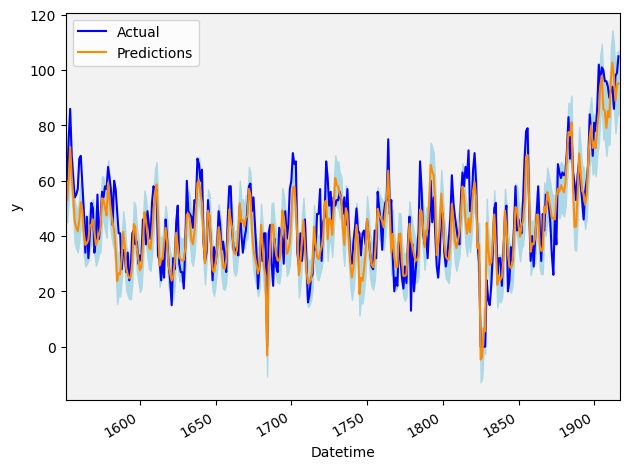

In [77]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(valid['y'], 'b-', label='Actual')
ax.plot(valid['yhat'], color='darkorange', label='Predictions')
# ax.plot(valid['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

ax.axvspan(1551, 1917, color='#808080', alpha=0.1)

ax.legend(loc='best')
# plt.xticks
plt.fill_between(x=valid.index, y1=valid['yhat_lower'], y2=valid['yhat_upper'], color='lightblue')
plt.xlim(1551, 1917)

fig.autofmt_xdate()
plt.tight_layout()

baselineよりMAEが高いモデルを作成できた。グラフからbaselineよりもトレンドを反映できているように見える。

特徴量を追加することによって評価が上がった。デフォルトの特徴量だけではなく、EDAで追加した特徴量も導入すると良いと思う。

Prophet予測値が曲線による近似のように見えるが、予測値がノイズの多いデータの変動をフィルタリングしたような滑らかな曲線を描いているからである。


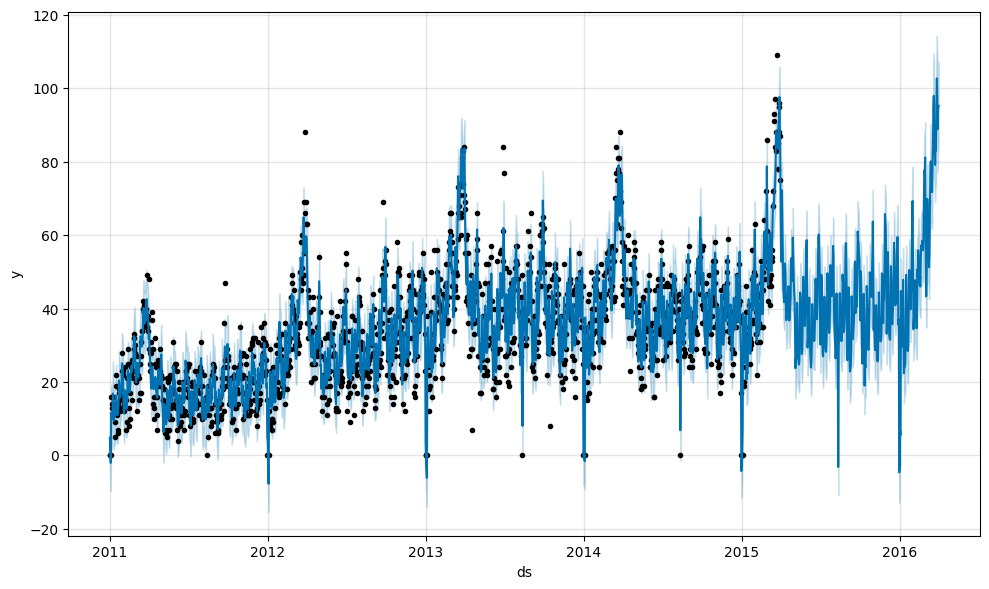

In [78]:
# Prophetを使って予測値をプロット
# ドットは訓練データ、実線はモデルの予測値、影付きの帯は80%信頼区間を表している
fig1 = m.plot(forecast)

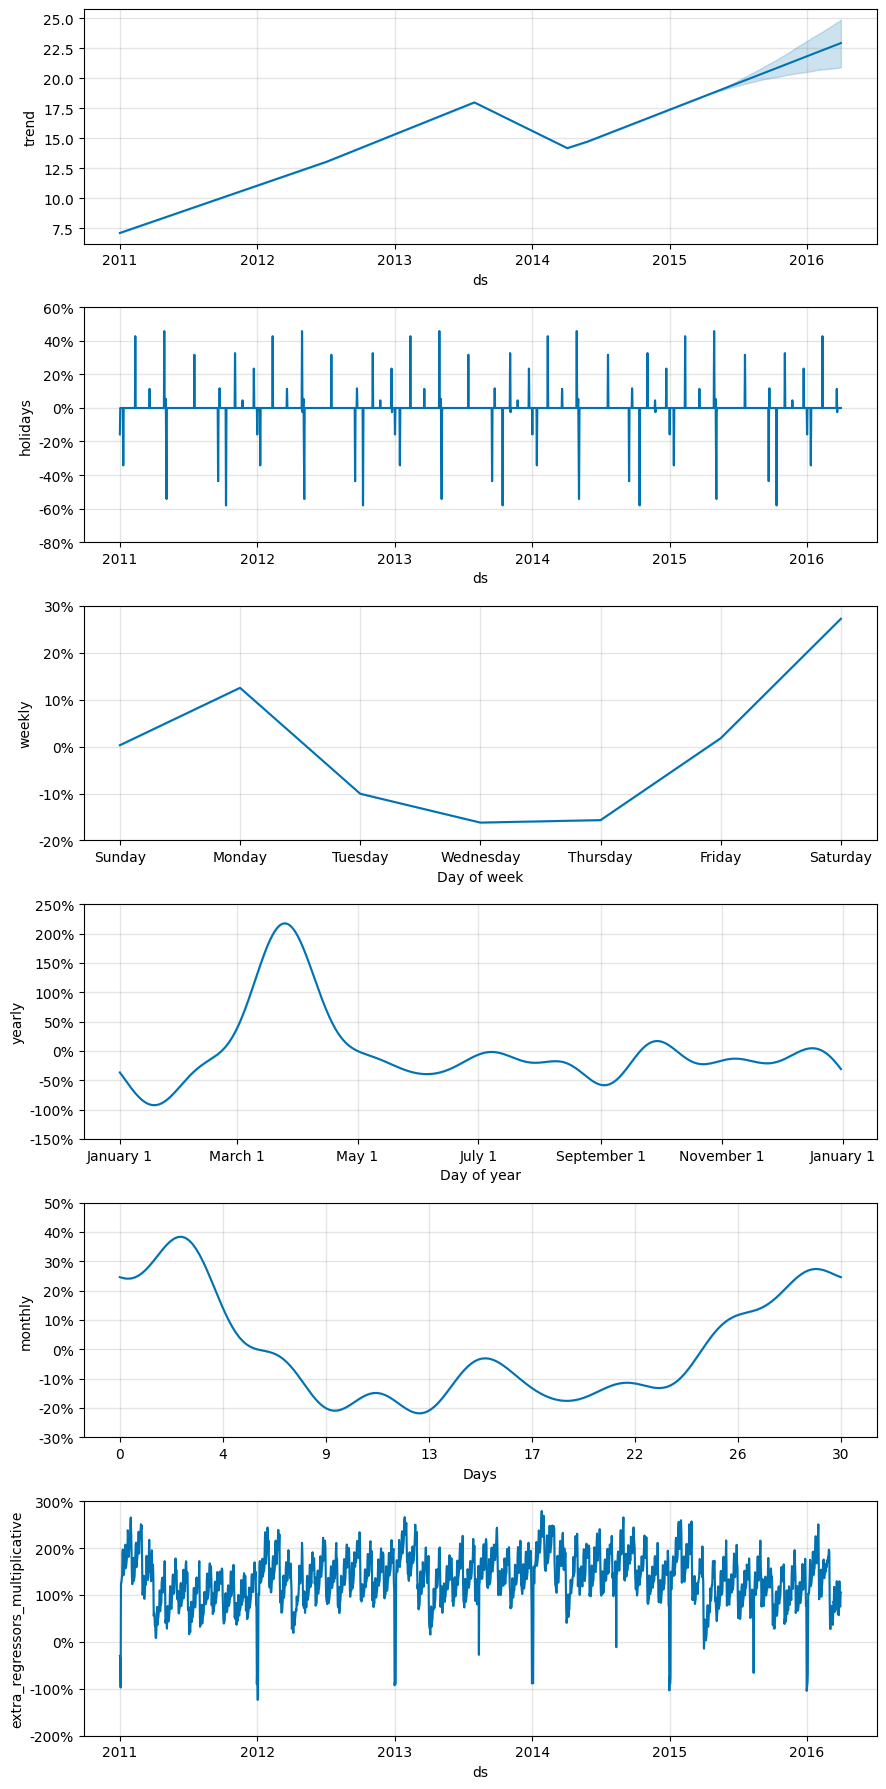

In [79]:
fig2 = m.plot_components(forecast)

トレンド、ホリデー影響、季節性（週次、月次、年次）を確認できる。
1. 増加傾向のトレンドを確認。2013年度はトレンドが下がっている。⇨なにか要因はあるか？
2. 休日ごとに値に影響あり。各年、傾向がほぼ一致しているのでホリデー効果はある用に見える。大きな負の値は年末年始の休業日と思われる。⇨休業日は必ず0なので、最後に0を上書きする。
3. 土曜日が最も高く、水曜日が最も低い。引越は休日に多く、週半ばは少ないという一般的に考え方に一致する。
4. 3月、4月が最も大きいことは事前情報あり。また3月4月の4Q終わりの他に、2Q, 3Q終わりにも多い傾向⇨1Q終わりが他のQより少ないことは理由があるのか？
5. 月末月初の引越数が多い。上旬は少ない傾向。


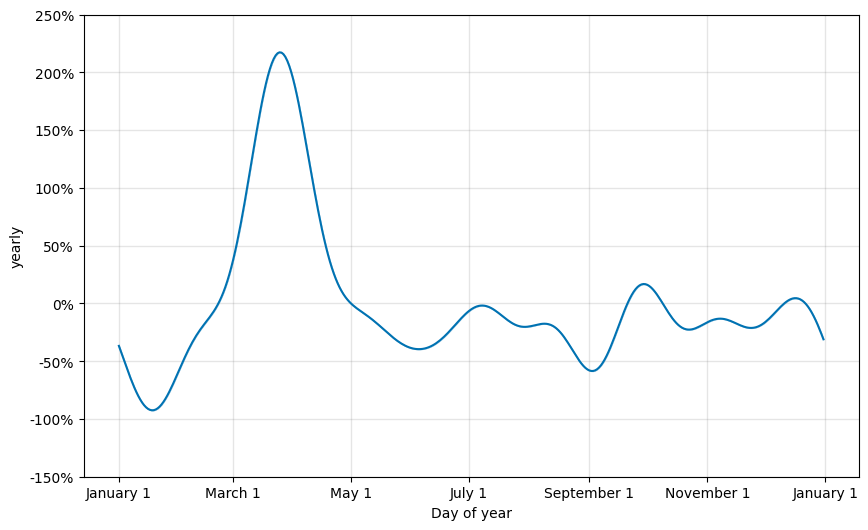

In [80]:
# 季節成分だけのプロット
from prophet.plot import plot_yearly, plot_weekly

fig4 = plot_yearly(m)

デフォルトでは、Prophetが年次の季節性を推定するために10項のフーリエ級数を使っている。フーリエ級数の工数を変更することも可能。

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/hul65qdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/jlfqgsc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95196', 'data', 'file=/tmp/tmpm3xeokjk/hul65qdv.json', 'init=/tmp/tmpm3xeokjk/jlfqgsc4.json', 'output', 'file=/tmp/tmpm3xeokjk/prophet_modelacu8pgjc/prophet_model-20240928142817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


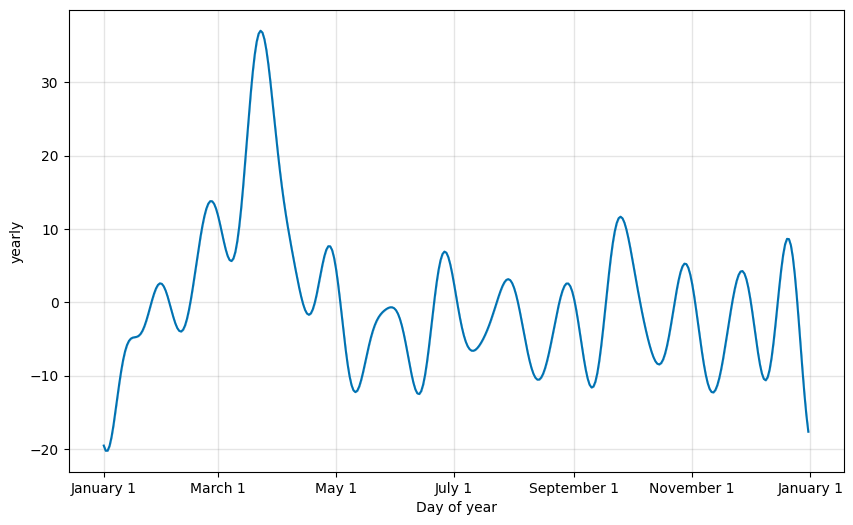

In [81]:
# 20項のフーリエ級数でグラフ描画
m2 = Prophet(yearly_seasonality=20).fit(train)
fig6 = plot_yearly(m2)

項数を増やすほうが、感度が高いことがわかるが、このパラメータを調整すると、フーリエ級数の項の数が多すぎる場合は過剰適合、項の数が少なすぎる場合は過少適合に陥る可能性がある。パラメータ調整で実施検討。

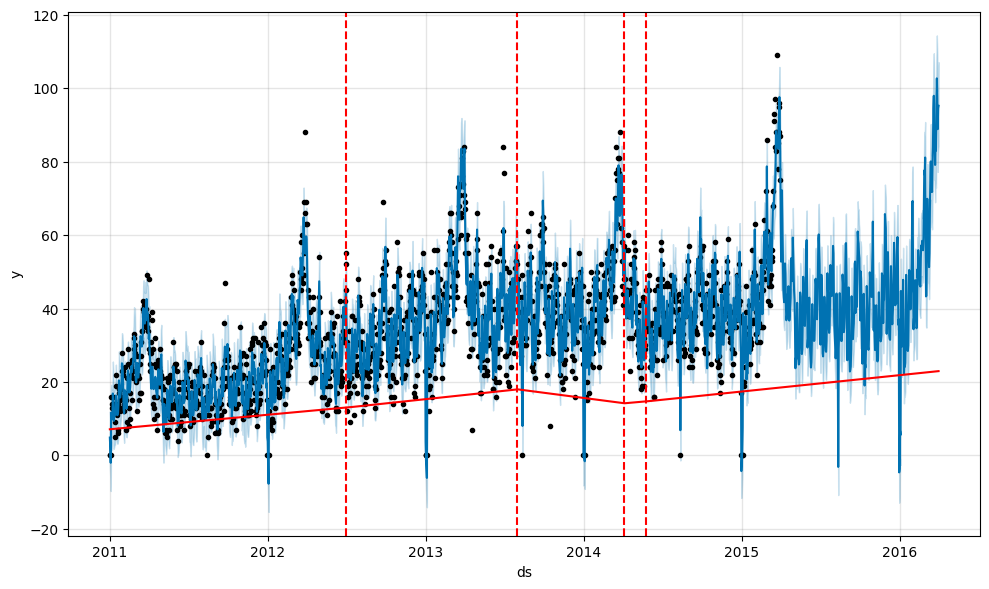

In [82]:
# トレンドの変曲点を確認
from prophet.plot import add_changepoints_to_plot

fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

In [83]:
# Prophetモデルのインスタンス作成
m = Prophet(yearly_seasonality=24, weekly_seasonality=4, seasonality_mode='multiplicative')

# 追加のレグレッサ（特徴量）をモデルに追加（yとdsを除くすべての列）
for column in df.columns.drop(['ds', 'y']):
    m.add_regressor(column)

# 日本の祝日を追加
m.add_country_holidays(country_name='Japan')

# 月次の季節性を追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=15)

# 訓練データを使用してモデルを学習
m.fit(train)

# 365日先までの予測用データフレームを作成
# future = m.make_future_dataframe(periods=365)
future = pd.concat([train, valid])

# 予測結果を生成
forecast = m.predict(future)

from sklearn.metrics import mean_absolute_error

# テストデータに予測値の成分をいれる
valid[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

# 予測値を出力
prophet_reg2_ff_mae = mean_absolute_error(valid['y'], valid['yhat'])
print('Prophet_reg2_ff予測値MAE:', prophet_reg2_ff_mae)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/5ygc0jqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/k6b90ga4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76421', 'data', 'file=/tmp/tmpm3xeokjk/5ygc0jqj.json', 'init=/tmp/tmpm3xeokjk/k6b90ga4.json', 'output', 'file=/tmp/tmpm3xeokjk/prophet_modelvw6ydspf/prophet_model-20240928142821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet_reg2_ff予測値MAE: 6.722716798665783


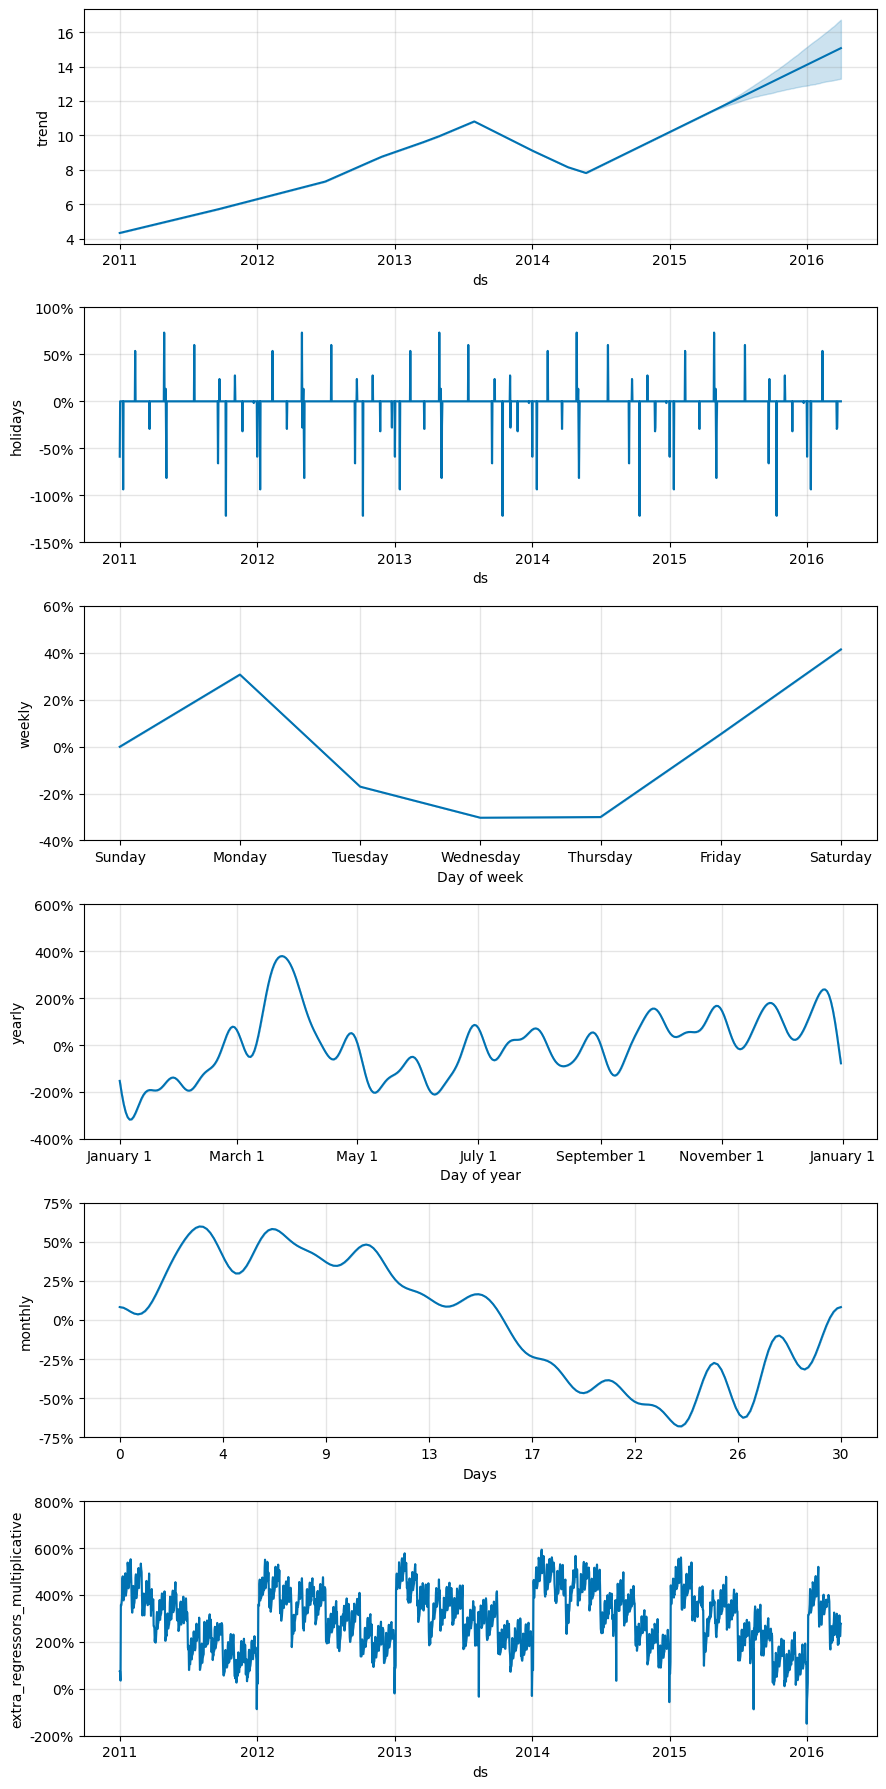

In [84]:
fig5 = m.plot_components(forecast)

Prophet_reg2_fy20予測値MAE: 6.8941749848833425

Prophet_reg2_fymw20予測値MAE: 6.836252582362756

Prophet_reg2_fymw30予測値MAE: 7.035949453947934

30項だと精度が悪くなった。20項で進める

Prophet_reg2_ff予測値MAE: 6.722716798665783

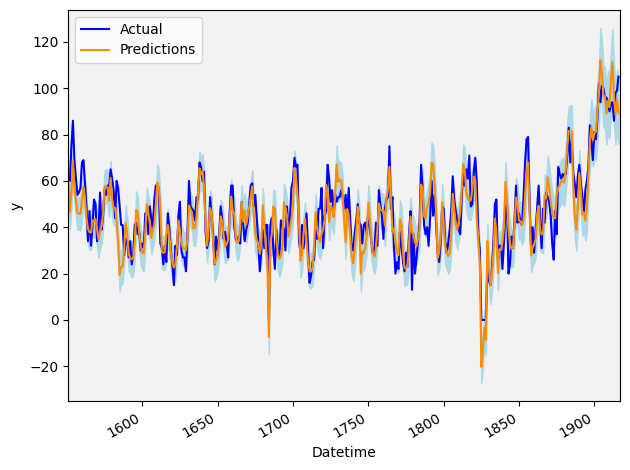

In [85]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(valid['y'], 'b-', label='Actual')
ax.plot(valid['yhat'], color='darkorange', label='Predictions')
# ax.plot(valid['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

ax.axvspan(1551, 1917, color='#808080', alpha=0.1)

ax.legend(loc='best')
# plt.xticks
plt.fill_between(x=valid.index, y1=valid['yhat_lower'], y2=valid['yhat_upper'], color='lightblue')
plt.xlim(1551, 1917)

fig.autofmt_xdate()
plt.tight_layout()

In [86]:
params_uni =  {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 50.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}

In [87]:
# Prophetモデルのインスタンス作成
m = Prophet(yearly_seasonality=24, weekly_seasonality=4, **params_uni)

# 追加のレグレッサ（特徴量）をモデルに追加（yとdsを除くすべての列）
for column in df.columns.drop(['ds', 'y']):
    m.add_regressor(column)

# 日本の祝日を追加
m.add_country_holidays(country_name='Japan')

# 月次の季節性を追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=15)

# 訓練データを使用してモデルを学習
m.fit(train)

# 365日先までの予測用データフレームを作成
# future = m.make_future_dataframe(periods=365)
future = pd.concat([train, valid])

# 予測結果を生成
forecast = m.predict(future)

from sklearn.metrics import mean_absolute_error

# テストデータに予測値の成分をいれる
valid[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

# 予測値を出力
prophet_reg2_ff_mae = mean_absolute_error(valid['y'], valid['yhat'])
print('Prophet_reg2_ff予測値MAE:', prophet_reg2_ff_mae)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/zx4y7896.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/nyvaa8xh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54663', 'data', 'file=/tmp/tmpm3xeokjk/zx4y7896.json', 'init=/tmp/tmpm3xeokjk/nyvaa8xh.json', 'output', 'file=/tmp/tmpm3xeokjk/prophet_model2xaxpjkq/prophet_model-20240928142827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet_reg2_ff予測値MAE: 6.638939300723905


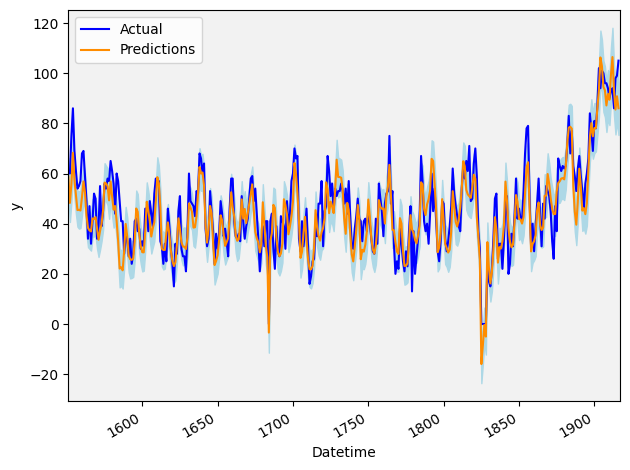

In [88]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(valid['y'], 'b-', label='Actual')
ax.plot(valid['yhat'], color='darkorange', label='Predictions')
# ax.plot(valid['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

ax.axvspan(1551, 1917, color='#808080', alpha=0.1)

ax.legend(loc='best')
# plt.xticks
plt.fill_between(x=valid.index, y1=valid['yhat_lower'], y2=valid['yhat_upper'], color='lightblue')
plt.xlim(1551, 1917)

fig.autofmt_xdate()
plt.tight_layout()

# ベースライン作成

In [89]:
merged_df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/merged_df_2.csv")

In [90]:
# ProphetのDataFrameに変換（ds:日付列、y:目的変数）
df = merged_df.rename(columns={"datetime": "ds"})
df['ds'] = pd.to_datetime(df["ds"])

# 別で時系列を作成するので削除
df.drop(['seasonal', 'trend', 'residual', 'y_bc_1_2', 'y_lag_365'], axis=1, inplace=True)

# 欠損値は一旦０に
df = df.fillna(0)

# trainデータの最後の１年を評価データセットする
train = df[:-365]
test = df[-365:]

In [91]:
params_uni = {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}

In [92]:
# trainデータの最後の１年を評価データセットする
train = df[:-365]
test = df[-365:]

# Prophetモデルのインスタンス作成（初期化）
m = Prophet(yearly_seasonality=24, weekly_seasonality=4, **params_uni)

# 追加のレグレッサ（特徴量）をモデルに追加（yとdsを除くすべての列）
for column in df.columns.drop(['ds', 'y']):
    m.add_regressor(column)

# 日本の祝日を追加
m.add_country_holidays(country_name='Japan')

# 月次の季節性を追加
m.add_seasonality(name='monthly', period=30.5, fourier_order=15)

# 訓練データを使用してモデルを学習
m.fit(train)

# 365日先までの予測用データフレームを作成
# future = m.make_future_dataframe(periods=365)
future = pd.concat([train, test])

# 予測結果を生成
forecast = m.predict(future)

# display(forecast.head(), forecast.tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/hizdlkl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/7f_6hsgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65081', 'data', 'file=/tmp/tmpm3xeokjk/hizdlkl5.json', 'init=/tmp/tmpm3xeokjk/7f_6hsgn.json', 'output', 'file=/tmp/tmpm3xeokjk/prophet_modelno4fosm8/prophet_model-20240928142831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [93]:
display(train.tail(), test.tail())

,ds,y,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,is_train,price_am_lag_1,...,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
1912,2016-03-27,94.0,1,5,4,50.57767,90.888889,87.785714,1,5.0,...,0,0,0,541071.836264,3.4,99.839900,107.683690,102.380890,99.09166,0.3
1913,2016-03-28,86.0,1,4,4,50.57767,78.866667,87.785714,1,5.0,...,0,0,0,541061.589011,3.4,99.846468,107.695412,102.367986,99.09166,0.3
1914,2016-03-29,98.0,1,4,4,50.57767,78.866667,87.785714,1,4.0,...,0,0,0,541051.341758,3.4,99.853036,107.707134,102.355083,99.09166,0.3
1915,2016-03-30,99.0,1,5,4,50.57767,90.888889,87.785714,1,4.0,...,0,0,0,541041.094505,3.4,99.859604,107.718856,102.342180,99.09166,0.3
1916,2016-03-31,105.0,1,5,4,50.57767,90.888889,87.785714,1,5.0,...,0,0,0,541030.847253,3.4,99.866172,107.730578,102.329277,99.09166,0.3


,ds,y,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,is_train,price_am_lag_1,...,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
2277,2017-03-27,0.0,0,5,4,40.748571,90.888889,87.785714,0,4.0,...,0,0,0,549193.033333,2.983871,100.214313,109.961056,103.229973,98.893476,0.3
2278,2017-03-28,0.0,0,4,4,40.748571,78.866667,87.785714,0,5.0,...,0,0,0,549216.786667,2.987097,100.227450,109.950684,103.249864,98.893476,0.3
2279,2017-03-29,0.0,0,3,3,40.748571,68.437500,76.615385,0,4.0,...,0,0,0,549240.540000,2.990323,100.240588,109.940313,103.269755,98.893476,0.3
2280,2017-03-30,0.0,0,4,3,40.748571,78.866667,76.615385,0,3.0,...,0,0,0,549264.293333,2.993548,100.253725,109.929942,103.289645,98.893476,0.3
2281,2017-03-31,0.0,1,5,4,50.577670,90.888889,87.785714,0,4.0,...,0,0,0,549288.046667,2.996774,100.266863,109.919571,103.309536,98.893476,0.3


In [94]:
from sklearn.metrics import mean_absolute_error

# テストデータに予測値の成分をいれる
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

# baselineカラムに予測範囲の１年前の範囲をいれる（評価用）
test['baseline'] = train['y'][-365:].values

In [95]:
# display(train.tail(), test.tail())

In [96]:
print("2016-08-16:", test[test["ds"] == "2016-08-16"].index)
print("2016-12-31:", test[test["ds"] == "2016-12-31"].index)

2016-08-16: Index([2054], dtype='int64')
2016-12-31: Index([2191], dtype='int64')


In [97]:
test.at[2054, "yhat"] = 0
test.at[2191, "yhat"] = 0
test.at[2192, "yhat"] = 0
test.at[2193, "yhat"] = 0
test.at[2194, "yhat"] = 0

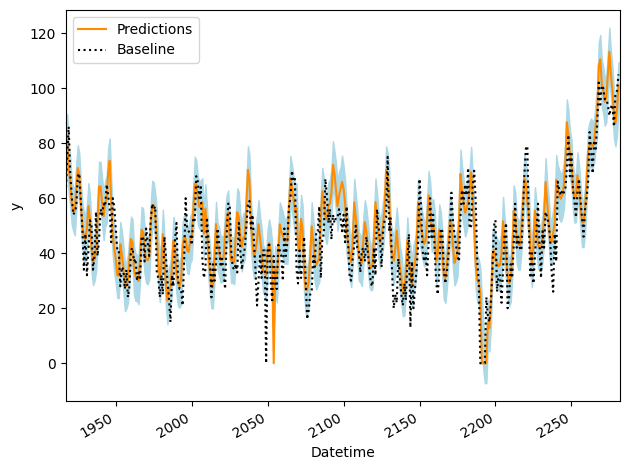

In [98]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['yhat'], color='darkorange', label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

# ax.axvspan(1551, 1917, color='#808080', alpha=0.1)

ax.legend(loc='best')
# # plt.xticks
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(1917, 2282)

fig.autofmt_xdate()
plt.tight_layout()

In [99]:
print("2015-08-12:", train[train["ds"] == "2015-08-12"].index)
print("2015-12-31:", train[train["ds"] == "2015-12-31"].index)
print("2016-02-29:", train[train["ds"] == "2016-02-29"].index)

2015-08-12: Index([1684], dtype='int64')
2015-12-31: Index([1825], dtype='int64')
2016-02-29: Index([1885], dtype='int64')


In [100]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# 検証データ（365日分）
train_validation_df = train["y"][-366:].copy()
pred_validation_df = test["yhat"].copy()

# 休業日およびうるう年を除外
train_validation_df.drop(index=[1684, 1688, 1825, 1826, 1827, 1828, 1885], inplace=True)
pred_validation_df.drop(index=[2049, 2054, 2191, 2192, 2193, 2194], inplace=True)

# インデックスの再設定
train_validation_df.reset_index(drop=True, inplace=True)
pred_validation_df.reset_index(drop=True, inplace=True)

# MAEの計算
mae_value = mean_absolute_error(train_validation_df, pred_validation_df)
print(f"Mean Absolute Error: {mae_value}")



Mean Absolute Error: 9.73454017922642


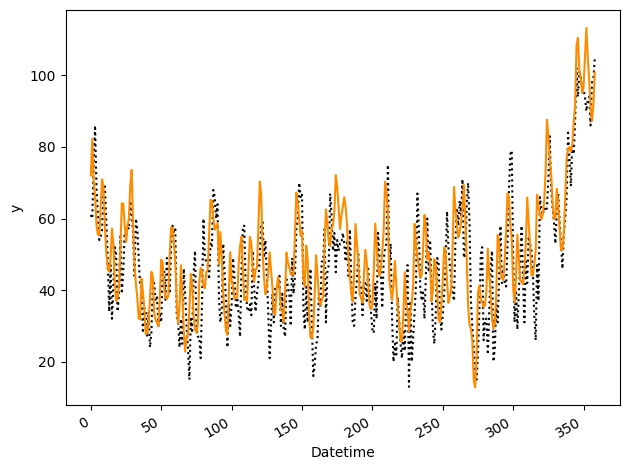

In [101]:
fig, ax = plt.subplots()

ax.plot(train_validation_df, 'k:', label='Baseline')
ax.plot(pred_validation_df, color='darkorange', label='Predictions')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

fig.autofmt_xdate()
plt.tight_layout()

# クロスバリデーション

交差検証とは、モデルを安定させるために、データセットの複数の期間にわたって予測を行うこと。
時系列では、データの順序が同じままでなければならない。交差検証では特定のカットオフ日で分割した訓練データのサブセットでモデルを訓練し、カットオフ日以降の特定の期間の予測を行うという方法で実行される。このカットオフ日をスライドさせることで、サブセットを徐々に増やながら予測期間をスライドさせていき、訓練データセット全体が使われるまで、このプロセスを繰り返す。

各設定値は以下のように設定される。
たとえば、initial='730 days'とperiod='180 days'を設定した場合、最初のカットオフ日は730日後。次のカットオフ日は、最初のカットオフ日から180日後。
また、horizonはテストデータの期間と一致させることが適切。

In [102]:
from prophet.diagnostics import  cross_validation

# initial：最初の訓練データの期間、period：カットオフ日、horizon：予測期間
df_cv = cross_validation(m, initial='730 days', period='365 days', horizon='365 days')
df_cv.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2013-04-01 00:00:00 and 2015-04-01 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/laoz0met.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/8wnmug85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49534', 'data', 'file=/tmp/tmpm3xeokjk/laoz0met.json', 'init=/tmp/tmpm3xeokjk/8wnmug85.json', 'output', 'file=/tmp/tmpm3xeokjk/prophet_modelzz7wbcxv/prophet_model-20240928142835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/kngt82n3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/pkgiehj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-04-02,56.146571,50.059466,62.577223,55.0,2013-04-01
1,2013-04-03,51.223346,44.684791,57.385702,59.0,2013-04-01
2,2013-04-04,46.418740,39.855370,52.462621,42.0,2013-04-01
3,2013-04-05,47.476361,40.594628,54.145496,43.0,2013-04-01
4,2013-04-06,61.158384,54.504661,68.163446,60.0,2013-04-01


In [103]:
from prophet.diagnostics import performance_metrics
from IPython.display import display

# rolling_window=0: 各カットオフごとの予測に対して、個別に誤差指標を算出する。これにより、細かい時系列でのモデル性能が確認可能。
# rolling_window=1: 期間全体にわたって評価指標が平均化する。期間全体でのモデルのパフォーマンスを把握することができる。
df_perf_0 = performance_metrics(df_cv, rolling_window=0)
df_perf_1 = performance_metrics(df_cv, rolling_window=1)

display(df_perf_0.head(), df_perf_1.head())

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,2.566772,1.602115,1.555172,0.034518,0.030568,1.000000
1,2 days,212.726346,14.585141,13.922537,0.227553,0.248854,0.000000
2,3 days,120.357848,10.970772,9.231284,0.118598,0.151250,0.666667
3,4 days,37.318208,6.108863,6.000676,0.104848,0.109542,1.000000
4,5 days,26.857233,5.182396,3.853005,0.036770,0.070343,1.000000


,horizon,mse,rmse,mae,mdape,smape,coverage
0,365 days,148.427436,12.18308,10.01939,0.214356,0.327996,0.429224


horizon：カットオフ日から予測が何日（または時間、月など）先を対象としているかを示すタイムデルタ。
たとえば、horizon=30 daysならば、カットオフ日から30日先の予測結果を示している。

Coverage：予測の信頼区間に実測値が収まる割合。

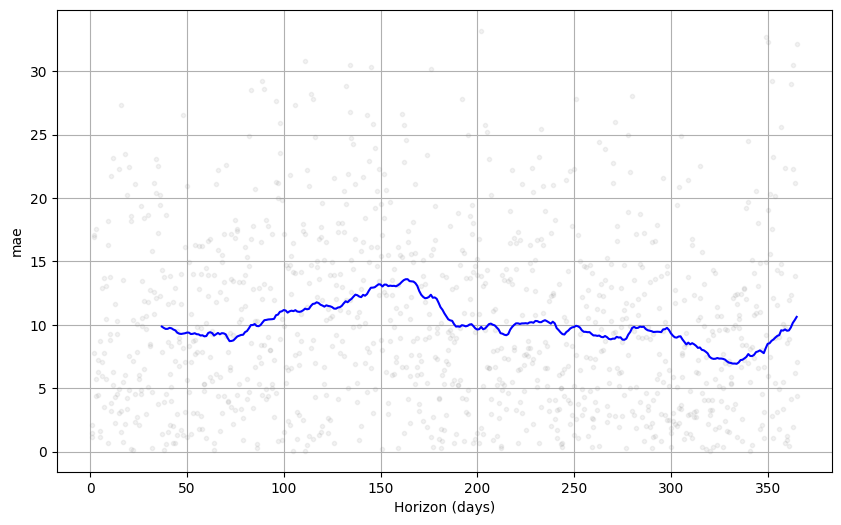

In [104]:
# 期間全体にわたるMAEの推移を可視化
from prophet.plot import plot_cross_validation_metric

fig7 = plot_cross_validation_metric(df_cv, metric='mae')

時間がたってもモデルの予測値の誤差が大きくならないことが理想的。

今回は誤差が上がって来ているので交差検証期間も調整してみるとよい。また、2011年の元データは他の特徴量が乏しいので、含めて調整すると良いかもしれない。
→元データでやったので不要

# ハイパーパラメータチューニング

以下の４つのパラメータを調整する。（他のパラメータもあるが以下で十分。）


●changepoint_prior_scale：
Prophet において最も影響力があるとされるパラメータ。トレンドの柔軟性、具体的には、トレンドの変化点でトレンドがどの程度変化するのかを決定する。このパラメータの値が小さすぎると、トレンドが過少適合になり、データで観測される分散がノイズとして扱われる。このパラメータの値が大きすぎると、ノイズの多い変動にトレンドが過剰適合する。[0.001, 0.01, 0.1, 0.5]の範囲で調整。


●seasonality_prior_scale：
季節成分の柔軟性を設定するパラメータ。このパラメータの値を大きくすると、季節成分がより小さな変動に適合できるようになる。このパラメータの値を小さくすると、季節成分がより滑らかになる。[0.01, 0.1, 1.0, 10.0] の範囲で調整。


●holidays_prior_scale：
ホリデー効果の柔軟性を設定するパラメータであり、seasonality_prior_scaleと同じような働きをする。[0.01, 0.1, 1.0, 10.0] の範囲で調整。


●seasonality_mode：
'additive'（加法）または'multiplicative'（乗法）のどちらかに設定できる。デフォルトは'additive'だが、季節的な変動が経時的に大きくなる場合は'multiplicative'に設定できる。この点については時系列をプロットすれば観測できるが、迷った場合は、ハイパーパラメータチューニングプロセスに追加してみるとよい。⇨季節性グラフが時間に対して増幅もしくは減衰している場合に'multiplicative'に設定する。

In [105]:
# from itertools import product

# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     "seasonality_mode": ['additive', 'multiplicative']
# }

# all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# maes = []

# for params in all_params:
#     m_cv = Prophet(yearly_seasonality=24, weekly_seasonality=4, **params)

#     # 追加のレグレッサ（特徴量）をモデルに追加（yとdsを除くすべての列）
#     for column in df.columns.drop(['ds', 'y']):
#         m_cv.add_regressor(column)

#     # 日本の祝日を追加
#     m_cv.add_country_holidays(country_name='Japan')

#     # 月次の季節性を追加
#     m_cv.add_seasonality(name='monthly', period=30.5, fourier_order=15)

#     m_cv.fit(train)

#     df_cv = cross_validation(m_cv, initial='730 days', period='365 days', horizon='365 days', parallel='processes')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     maes.append(df_p['mae'].values[0])

# tuning_results = pd.DataFrame(all_params)
# tuning_results['mae'] = maes


In [106]:
# best_params = all_params[np.argmin(maes)]
# print(best_params)

In [107]:
# filtered_results = tuning_results[tuning_results['mae'] < 9]
# filtered_results

In [108]:
best_params = {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}

In [109]:
params_uni =  {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 50.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}

In [110]:
merged_df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/merged_df_2.csv")

In [111]:
# ProphetのDataFrameに変換（ds:日付列、y:目的変数）
df = merged_df.rename(columns={"datetime": "ds"})
df['ds'] = pd.to_datetime(df["ds"])

# 別で時系列を作成するので削除
df.drop(['seasonal', 'trend', 'residual', 'y_bc_1_2', 'y_lag_365'], axis=1, inplace=True)

# 欠損値は一旦０に
df = df.fillna(0)

# trainデータの最後の１年を評価データセットする
train = df[:-365]
test = df[-365:]

In [112]:
# Prophetモデルのインスタンス作成（初期化）
m_best = Prophet(yearly_seasonality=24, weekly_seasonality=4, **params_uni)

# 追加のレグレッサ（特徴量）をモデルに追加（yとdsを除くすべての列）
for column in df.columns.drop(['ds', 'y']):
    m_best.add_regressor(column)

# 日本の祝日を追加
m_best.add_country_holidays(country_name='Japan')

# 月次の季節性を追加
m_best.add_seasonality(name='monthly', period=30.5, fourier_order=15)

# 訓練データを使用してモデルを学習
m_best.fit(train)

# 365日先までの予測用データフレームを作成
future = pd.concat([train, test])

# 予測結果を生成
forecast = m_best.predict(future)

# baselineカラムに予測範囲の１年前の範囲をいれる（評価用）
test['baseline'] = train['y'][-365:].values
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

# 休業日の実績を0にする
test.at[2054, "yhat"] = 0
test.at[2191, "yhat"] = 0
test.at[2192, "yhat"] = 0
test.at[2193, "yhat"] = 0
test.at[2194, "yhat"] = 0

display(forecast.head(), forecast.tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/28b30h8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3xeokjk/xtid19ll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36704', 'data', 'file=/tmp/tmpm3xeokjk/28b30h8r.json', 'init=/tmp/tmpm3xeokjk/xtid19ll.json', 'output', 'file=/tmp/tmpm3xeokjk/prophet_modelcsm4ty9k/prophet_model-20240928142842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Autumnal Equinox,Autumnal Equinox_lower,Autumnal Equinox_upper,Children's Day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,20.187127,-4.079151,11.826436,20.187127,20.187127,0.0,0.0,0.0,0.0,...,0.132044,0.132044,0.132044,-0.329940,-0.329940,-0.329940,0.0,0.0,0.0,4.048858
1,2011-01-02,20.202555,-7.837412,8.153212,20.202555,20.202555,0.0,0.0,0.0,0.0,...,0.132044,0.132044,0.132044,-0.426353,-0.426353,-0.426353,0.0,0.0,0.0,0.338145
2,2011-01-03,20.217984,-10.306219,5.765761,20.217984,20.217984,0.0,0.0,0.0,0.0,...,0.132044,0.132044,0.132044,-0.502382,-0.502382,-0.502382,0.0,0.0,0.0,-2.620579
3,2011-01-04,20.233412,0.009298,15.691995,20.233412,20.233412,0.0,0.0,0.0,0.0,...,0.132044,0.132044,0.132044,-0.553742,-0.553742,-0.553742,0.0,0.0,0.0,7.468477
4,2011-01-05,20.248840,-2.112819,13.507938,20.248840,20.248840,0.0,0.0,0.0,0.0,...,0.132044,0.132044,0.132044,-0.578735,-0.578735,-0.578735,0.0,0.0,0.0,5.683418


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Autumnal Equinox,Autumnal Equinox_lower,Autumnal Equinox_upper,Children's Day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2277,2017-03-27,72.493926,105.028096,125.291726,68.598228,76.187382,0.0,0.0,0.0,0.0,...,-0.237847,-0.237847,-0.237847,0.939761,0.939761,0.939761,0.0,0.0,0.0,115.058808
2278,2017-03-28,72.528303,94.843768,113.989242,68.610331,76.234588,0.0,0.0,0.0,0.0,...,-0.237847,-0.237847,-0.237847,0.914479,0.914479,0.914479,0.0,0.0,0.0,104.894246
2279,2017-03-29,72.562680,94.376279,114.970424,68.622114,76.281794,0.0,0.0,0.0,0.0,...,-0.237847,-0.237847,-0.237847,0.877788,0.877788,0.877788,0.0,0.0,0.0,104.967033
2280,2017-03-30,72.597057,102.645505,122.118251,68.622979,76.329001,0.0,0.0,0.0,0.0,...,-0.237847,-0.237847,-0.237847,0.830332,0.830332,0.830332,0.0,0.0,0.0,112.736957
2281,2017-03-31,72.631435,112.864143,132.980394,68.623844,76.376207,0.0,0.0,0.0,0.0,...,-0.237847,-0.237847,-0.237847,0.773758,0.773758,0.773758,0.0,0.0,0.0,123.387022


In [113]:
train_merged = pd.merge(train, forecast, on="ds", how="left")
train_merged.tail()

,ds,y,client_x,price_am_x,price_pm_x,client_mean_x,price_am_mean_x,price_pm_mean_x,is_train_x,price_am_lag_1_x,...,year_y,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1912,2016-03-27,94.0,1,5,4,50.57767,90.888889,87.785714,1,5.0,...,-0.176198,-0.176198,-0.176198,0.934509,0.934509,0.934509,0.0,0.0,0.0,105.416810
1913,2016-03-28,86.0,1,4,4,50.57767,78.866667,87.785714,1,5.0,...,-0.176198,-0.176198,-0.176198,0.906368,0.906368,0.906368,0.0,0.0,0.0,95.864776
1914,2016-03-29,98.0,1,4,4,50.57767,78.866667,87.785714,1,4.0,...,-0.176198,-0.176198,-0.176198,0.866886,0.866886,0.866886,0.0,0.0,0.0,89.167474
1915,2016-03-30,99.0,1,5,4,50.57767,90.888889,87.785714,1,4.0,...,-0.176198,-0.176198,-0.176198,0.816958,0.816958,0.816958,0.0,0.0,0.0,94.846945
1916,2016-03-31,105.0,1,5,4,50.57767,90.888889,87.785714,1,5.0,...,-0.176198,-0.176198,-0.176198,0.758471,0.758471,0.758471,0.0,0.0,0.0,94.475561


In [114]:
test_merged = pd.merge(train, forecast, on="ds", how="left")
test_merged.tail()

,ds,y,client_x,price_am_x,price_pm_x,client_mean_x,price_am_mean_x,price_pm_mean_x,is_train_x,price_am_lag_1_x,...,year_y,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1912,2016-03-27,94.0,1,5,4,50.57767,90.888889,87.785714,1,5.0,...,-0.176198,-0.176198,-0.176198,0.934509,0.934509,0.934509,0.0,0.0,0.0,105.416810
1913,2016-03-28,86.0,1,4,4,50.57767,78.866667,87.785714,1,5.0,...,-0.176198,-0.176198,-0.176198,0.906368,0.906368,0.906368,0.0,0.0,0.0,95.864776
1914,2016-03-29,98.0,1,4,4,50.57767,78.866667,87.785714,1,4.0,...,-0.176198,-0.176198,-0.176198,0.866886,0.866886,0.866886,0.0,0.0,0.0,89.167474
1915,2016-03-30,99.0,1,5,4,50.57767,90.888889,87.785714,1,4.0,...,-0.176198,-0.176198,-0.176198,0.816958,0.816958,0.816958,0.0,0.0,0.0,94.846945
1916,2016-03-31,105.0,1,5,4,50.57767,90.888889,87.785714,1,5.0,...,-0.176198,-0.176198,-0.176198,0.758471,0.758471,0.758471,0.0,0.0,0.0,94.475561


In [115]:
train_merged.to_csv("train_merged.csv", index=False)
test_merged.to_csv("test_merged.csv", index=False)

In [116]:
test["lower_diff"] = test["yhat"] - test["yhat_lower"]
test["upper_diff"] = test["yhat_upper"] - test["yhat"]

print(test["lower_diff"])
print(test["lower_diff"].mean())
print(test["upper_diff"])
print(test["upper_diff"].mean())

1917     7.211241
1918     7.750268
1919     7.919320
1920     8.166702
1921     7.608075
          ...    
2277    10.030712
2278    10.050478
2279    10.590755
2280    10.091452
2281    10.522879
Name: lower_diff, Length: 365, dtype: float64
8.139724085627725
1917     8.516970
1918     8.015303
1919     7.886830
1920     7.591529
1921     7.854472
          ...    
2277    10.232918
2278     9.094996
2279    10.003391
2280     9.381293
2281     9.593372
Name: upper_diff, Length: 365, dtype: float64
7.881493384659567


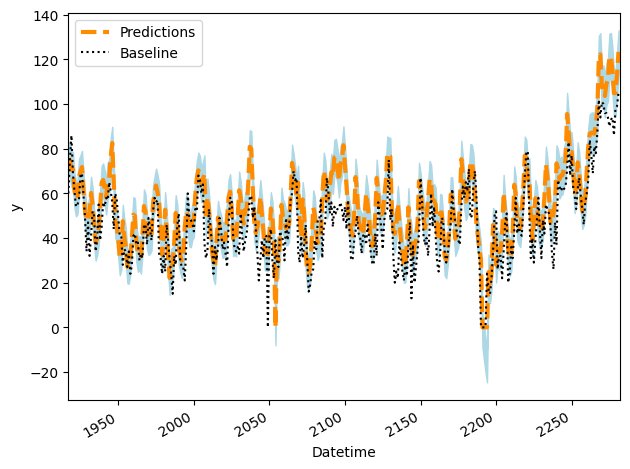

In [117]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Datetime')
ax.set_ylabel('y')

# ax.axvspan(1733, 2098, color='#808080', alpha=0.1)

ax.legend(loc='best')
# # plt.xticks
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(1917, 2282)

fig.autofmt_xdate()
plt.tight_layout()

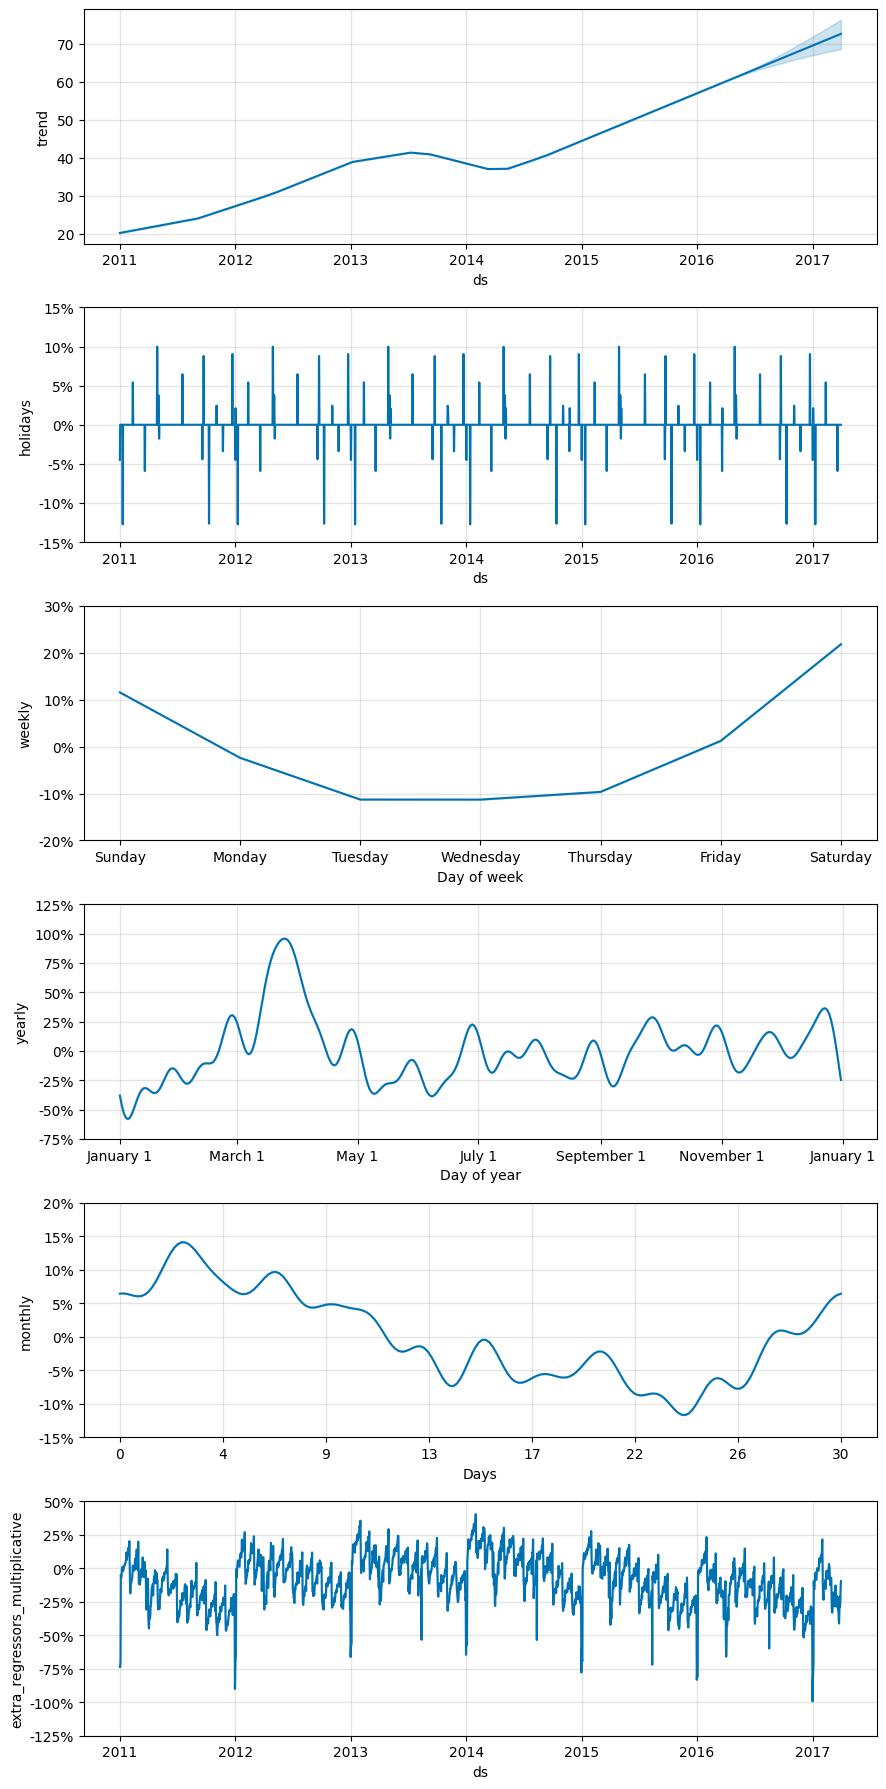

In [118]:
fig = m_best.plot_components(forecast)

chatGTPからのコメント
1. 過剰な複雑化 (過学習)
原因: ハイパーパラメータの組み合わせが複雑すぎて、モデルがトレーニングデータに過剰に適合し、汎化性能が低下する可能性があります。
対策: モデルの複雑さを抑えるために、changepoint_prior_scale や seasonality_prior_scale などの値をもう少し大きめに設定するなど、簡単なモデルを優先して試す。
2. クロスバリデーション設定のミスマッチ
原因: cross_validation の設定が不適切で、テストデータの期間やサンプル数と合っていない可能性があります。たとえば、 initial や horizon の設定が実際のデータ分布とミスマッチしていると、過去のデータに基づく予測が未来に対して適切でない場合があります。
対策: initial、period、horizon の設定を見直し、データの分布に合った設定に変更します。
3. 誤ったパラメータ範囲の選択
原因: holidays_prior_scale などのパラメータが過度に小さいか大きい値に設定されると、祝日や季節性の影響が適切に考慮されず、予測が不正確になる可能性があります。
対策: holidays_prior_scale や他のスケールパラメータをもう少し細かく設定して、幅広い範囲で試してみる（例: 0.05 や 5.0 など）。
4. 祝日効果が実際にない可能性
原因: データの特性として祝日の影響が大きくない場合、 holidays_prior_scale がモデルに負荷を与えてしまい、不要なノイズとして扱われる可能性があります。
対策: 祝日を含めた設定と、含めない設定の両方を比較してみることで、祝日が本当に重要な特徴かどうかを検証します。
5. トレーニングデータの不足や分布の偏り
原因: トレーニングデータが少なすぎたり、特定の期間に偏っていると、モデルの性能がテストデータに対して悪化する可能性があります。
対策: トレーニングデータのサイズを増やす、またはデータの前処理を改善してモデルに提供するデータの質を向上させる。
6. データの前処理ミス
原因: モデルに入力する前にデータの前処理で何らかの問題が発生し、適切なデータがモデルに渡っていない可能性があります（例: 外れ値処理や欠損値処理が不適切）。
対策: データのクリーンアップを再度見直し、外れ値や欠損値の処理を丁寧に行います。


# 提出データ作成

In [119]:
df_submit = pd.DataFrame({
    'datetime': sample_submit.iloc[:, 0].reset_index(drop=True),
    'y': test["yhat"].reset_index(drop=True)
})

display(df_submit.head(), df_submit.tail())

,datetime,y
0,2016-04-01,74.700094
1,2016-04-02,75.046542
2,2016-04-03,70.774873
3,2016-04-04,70.999620
4,2016-04-05,61.224945


,datetime,y
360,2017-03-27,115.058808
361,2017-03-28,104.894246
362,2017-03-29,104.967033
363,2017-03-30,112.736957
364,2017-03-31,123.387022


In [121]:
df_submit.to_csv("submit_moving22.csv", index=False, header=False)